# ДЗ №1. Разведочный  анализ

**ФИО**: Михайлов Михаил Дмитриевич  
**Группа**: 24.М41-мм (магистратура по направлению "Математическое обеспечение и администрирование информационных систем")  
**Дата сдачи**: 17.11.24  


## 1. Чтение и ознакомление с данными

В качестве датасета взяты данные о пассажирах титаника. Источник: [Kaggle](https://www.kaggle.com/competitions/titanic).

In [1]:
# imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns 

# typing
from numpy.typing import ArrayLike
from typing import Tuple, Optional, Literal


Прочитаем данные и посмотрим какие есть признаки:

In [2]:
df = pd.read_csv('../data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- ``PassengerID``: уникальный ID пассажира. Нужен для проверяющей системы
- ``Survived``: статус пассажира (пережил кораблекрушение или нет)
- ``Pclass``: класс пассажира (первый, второй и третий)
- ``Name``, ``Sex``, ``Age``: имя, возраст и пол
- ``SibSp``, ``Parch``: число братьев и сестер на корабле, число родителей/детей для данного пассажира
- ``Ticket``, ``Fare``: --- билет, стоимость проезда
- ``Cabin``: номер кабины
- ``Embarked``: --- порт отправления

Задача, которую хочется здесь решать --- задача бинарной классификации. На основании информации о пассажире вывести значение метки ``Survived`` для этого пассажира.
Посмотрим на колонки поподробнее:

In [3]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Итого:
- 2 пропуска в колонке ``Embarked``
- 177 пропусков в колонке ``Age``
- 687 пропусков в колонке ``Cabin``

Посмотрим на числовые колонки:

In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Средний возраст пассажира - 29.6 лет, априорные шансы на выживание: 38%.  
Стоимость проезда составляла в среднем 32 у.е., при этом были пассажиры, которые не заплатили за проезд, и пассажиры которые заплатили больше 500 у.е.

## 2. Подготовка датасета.

Порядок такой:
1. Всякие мелочи --- переименование колонок, выставление правильных типов.
2. Создание новых признаков. 
3. Работа с пропущенными значениями (data cleaning)


### 2.1 Всякие мелочи
1. Переименование колонок.
2. Удаление колонки ID.
3. Выставление правильных типов у колонок. 

In [5]:
# columns to lower case
df.rename(columns = lambda x: x.lower(), inplace = True)
df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Удалим дубликаты и ID пассажиров:

In [6]:
df = df.drop_duplicates()
df.drop(columns = ['passengerid'], inplace = True)

Конвертируем ``sex`` в бинарный признак:

In [7]:
# convert sex to binary feature
df['sex'] = df['sex'].replace(to_replace=['male', 'female'], value = ['0', '1']).astype(int)
df.rename(columns={'sex':'female'}, inplace = True)
df.head()

,survived,pclass,name,female,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


Конвертируем ``pclass`` в категориальный признак (с заданным порядком)

In [8]:
# convert ticket class to (ordinal) categorical type
TicketClass = [1,2,3]
df['pclass'] = df['pclass'].astype(dtype="category")
df['pclass'] = df['pclass'].cat.reorder_categories(TicketClass, ordered=True)

### 2.2 Создание новых признаков

Опишем признаки, которые добавим в датасет:

- Извлечем из имени информацию о семейном положении ("женат/не женат" и "ребенок на судне с родителями/не ребенок")
- По номеру каюты извлечем уровень палубы и ее номер (нумерация примерно одинаковая на всех палубах). Каюты разделим на группы по 25 и получим категориальный признак, который кодирует информацию о том где территориально находилась каюта пассажира
- Из номера билета сложно извлечь какую-то информацию, я ограничусь тем что сделаю бинарный признак: билет с префиксом или без.

In [9]:
def is_married(name: str) -> int:
    return int(('Mr.' in name) or ('Mrs.' in name))

def is_child(name: str) -> int:
    return int(('Master.' in name))

def cabin_level(cabin: str) -> Literal['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']:
    return cabin.split(' ')[0][0]
    
def cabin_number(cabin: str) -> str:
    if len(cabin.split(' ')[-1]) == 1:
        return np.nan
    return int(cabin.split(' ')[-1][1:])

def is_ticket_with_prefix(ticket: str) -> int:
    return int(not ticket.split(' ')[0].isdigit())

In [10]:
# Set all values by default to NA
df['cabin_number'] = np.nan
df['cabin_level']  = pd.NA

# Extract feautres from cabin number
df['cabin_number'] = df[~df['cabin'].isna()]['cabin'].apply(cabin_number)
df['cabin_level']  = df[~df['cabin'].isna()]['cabin'].apply(cabin_level).astype('category')

# Set cabin level as ordinal dtype: from bottom to top
CabinLevel = ['T', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
df['cabin_level'] = df['cabin_level'].astype(dtype="category")
df['cabin_level'] = df['cabin_level'].cat.reorder_categories(CabinLevel, ordered=True)

# Group cabins by their numbers
df['cabin_group'] = pd.cut(df['cabin_number'], bins = np.arange(0, 151, 25), labels = [f'cn_{i}_{i+25}' \
                                                                                       for i in np.arange(0, 150, 25)]).astype('category').cat.as_unordered()

Добавим бинарные признаки кодирующие информацию о семейном положении:

In [11]:
df['child']   = df['name'].apply(is_child)
df['married'] = df['name'].apply(is_married)

Также добавим признак "билет с префиксом":

In [12]:
df['ticket_prefixed'] = df['ticket'].apply(is_ticket_with_prefix)

Наконец, сделаем one-hot encoding категориальных признаков:

In [13]:
df = df.join(pd.get_dummies(df['embarked'], prefix = 'is_embarked_at', dtype=int))
df = df.join(pd.get_dummies(df['cabin_level'], prefix = 'is_cabin_level', dtype=int))
df = df.join(pd.get_dummies(df['pclass'], prefix = 'is_pclass', dtype=int))
df = df.join(pd.get_dummies(df['cabin_group'], prefix = 'is_cabin_group', dtype=int))

Получили:

In [14]:
df.head()

,survived,pclass,name,female,age,sibsp,parch,ticket,fare,cabin,...,is_cabin_level_G,is_pclass_1,is_pclass_2,is_pclass_3,is_cabin_group_cn_0_25,is_cabin_group_cn_25_50,is_cabin_group_cn_50_75,is_cabin_group_cn_75_100,is_cabin_group_cn_100_125,is_cabin_group_cn_125_150
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,...,0,0,0,1,0,0,0,0,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,...,0,1,0,0,0,0,0,1,0,0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,0,0,0,1,0,0,0,0,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,...,0,1,0,0,0,0,0,0,1,0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,...,0,0,0,1,0,0,0,0,0,0


In [15]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   survived                   891 non-null    int64   
 1   pclass                     891 non-null    category
 2   name                       891 non-null    object  
 3   female                     891 non-null    int32   
 4   age                        714 non-null    float64 
 5   sibsp                      891 non-null    int64   
 6   parch                      891 non-null    int64   
 7   ticket                     891 non-null    object  
 8   fare                       891 non-null    float64 
 9   cabin                      204 non-null    object  
 10  embarked                   889 non-null    object  
 11  cabin_number               200 non-null    float64 
 12  cabin_level                204 non-null    category
 13  cabin_group                200 non-

Несколько идей которые можно было бы реализовать, но соотношение усилие/результат не соответствуют задаче:
1. Можно воспользоваться картой [корабля](https://www.encyclopedia-titanica.org/titanic-deckplans/b-deck.html), чтобы посчитать расстояние от каюты до лестницы в каких-то условных единицах или даже в метрах.
2. Эту же карту можно использовать, для того чтобы создать категориальный признак "локация кабины"
3. Также, можно воспользоваться картой, чтобы подсчитать расстояние от места столкновения корабля с айсбергом до каюты.


Дальше, мы можем пытаться использовать родственные связи, чтобы генерировать признаки. Например "*есть ребенок, который выжил*" или "*есть супруг/супруга которая не выжила*". Для таких признаков необходимо подглядывать в значение целевой переменной (survived) и непонятно, хорошо ли так делать, или нет. В принципе, это проблема связанная с тем что признаки зависимы между разными пассажирами (так, логично предположить что если есть ребенок который выжил, то у его родителя шансы выжить больше, чем априорные), и непонятно как эту зависимость эксплуатировать. 

### 2.3  Очистка данных

В качестве значения для пропущенного возраста возьмем медианный возраст пассажиров (возьмем группы по полу --- известно что пол довольно сильно влияет на значение survived, чтобы было точнее):

In [16]:
df.loc[(df['age'].isna()) & (df['female'] == 1), 'age'] = df[(df['female'] == 1) & (~df['age'].isna())]['age'].median()
df.loc[(df['age'].isna()) & (df['female'] == 0), 'age'] = df[(df['female'] == 0) & (~df['age'].isna())]['age'].median()

Пропуски в колонках ``cabin_number`` и ``cabin_level`` заполнять не будем, для них сделан one-hot encoding (можно считать что na --- отдельная категория и чтобы колонки не были линейно зависимы, мы бинарный признак ``is_cabin_level_NA`` удаляем из нашего набора данных). В принципе, можно было бы использовать KNNimmuter, или воспользоваться открытыми данными (см. ниже)

In [17]:
df[df['embarked'].isna()].head()

,survived,pclass,name,female,age,sibsp,parch,ticket,fare,cabin,...,is_cabin_level_G,is_pclass_1,is_pclass_2,is_pclass_3,is_cabin_group_cn_0_25,is_cabin_group_cn_25_50,is_cabin_group_cn_50_75,is_cabin_group_cn_75_100,is_cabin_group_cn_100_125,is_cabin_group_cn_125_150
61,1,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,...,0,1,0,0,0,1,0,0,0,0
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,...,0,1,0,0,0,1,0,0,0,0


Согласно [данным](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html) с Encyclopedia Titanica, Martha Evelyn и Icard, Miss. Amelie погрузились на титаник в Саутгемптоне. 

In [18]:
df.loc[[61, 829], 'embarked'] = 'S'
df.loc[[61, 829], 'is_embarked_as_S'] = 1

Удалим колонки из которых мы уже извлекли информацию

In [19]:
df = df.drop(columns = ['name', 'cabin', 'ticket'])

Получили такой датасет:

In [20]:
df.head()

,survived,pclass,female,age,sibsp,parch,fare,embarked,cabin_number,cabin_level,...,is_pclass_1,is_pclass_2,is_pclass_3,is_cabin_group_cn_0_25,is_cabin_group_cn_25_50,is_cabin_group_cn_50_75,is_cabin_group_cn_75_100,is_cabin_group_cn_100_125,is_cabin_group_cn_125_150,is_embarked_as_S
0,0,3,0,22.0,1,0,7.2500,S,NaN,NaN,...,0,0,1,0,0,0,0,0,0,NaN
1,1,1,1,38.0,1,0,71.2833,C,85.0,C,...,1,0,0,0,0,0,1,0,0,NaN
2,1,3,1,26.0,0,0,7.9250,S,NaN,NaN,...,0,0,1,0,0,0,0,0,0,NaN
3,1,1,1,35.0,1,0,53.1000,S,123.0,C,...,1,0,0,0,0,0,0,1,0,NaN
4,0,3,0,35.0,0,0,8.0500,S,NaN,NaN,...,0,0,1,0,0,0,0,0,0,NaN


Несколько идей которые можно было бы реализовать, но соотношение усилие/результат не соответствуют задаче:
1. В принципе, есть открытая [информация](https://www.encyclopedia-titanica.org/cabins.html) о пассажирах, которую можно распарсить и использовать восстановления номеров кабин.
2. Также существует [вики-проект](https://titanic.fandom.com/wiki/Special:AllPages), посвященный катастрофе, на котором можно найти пропущенные значения возраста.


## 3. Исследование данных

### Корреляционный анализ

Мы начнем с построения матрицы корреляций признаков. Так как в данных много ординальных признаков, будем использовать корреляцию Спирмена.

<Axes: >

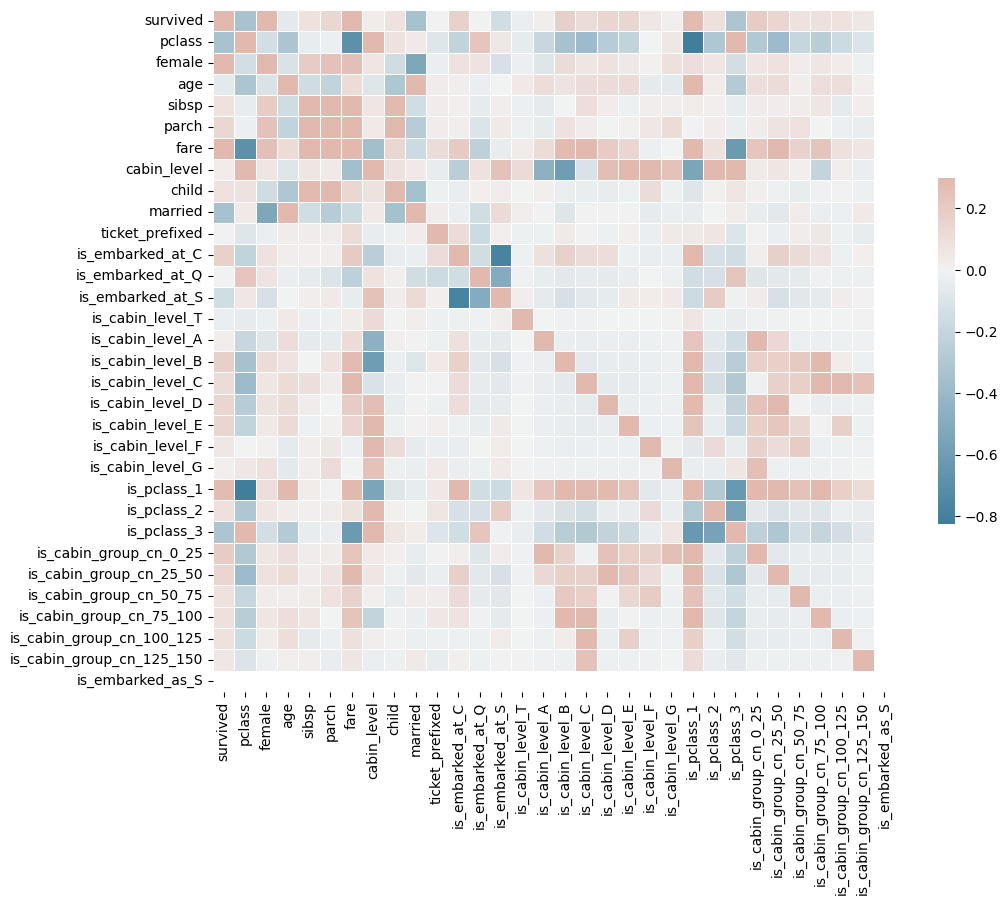

In [21]:
f, ax = plt.subplots(figsize=(11, 9))

df_categorical_columns = ['embarked', 'cabin_number', 'cabin_group']
corr = df.drop(columns = df_categorical_columns).rank().corr(method='spearman')
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, vmax=.3, center=0, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Несколько наблюдений
- is_pclass_1 сильно коррелирован с бинарными признаками для кабины. Это связано с тем что данные по кабинам в основном сохранились для пассажиров первого класса
- survived сильно коррелирован с ``female``, ``fare``, ``pclass`` и ``married``

Посмотрим на то как распределены числовые признаки:

### Распределение признаков

Посмотрим на гистограммы отражающие долю выживших по значениям ``fare`` и ``age``

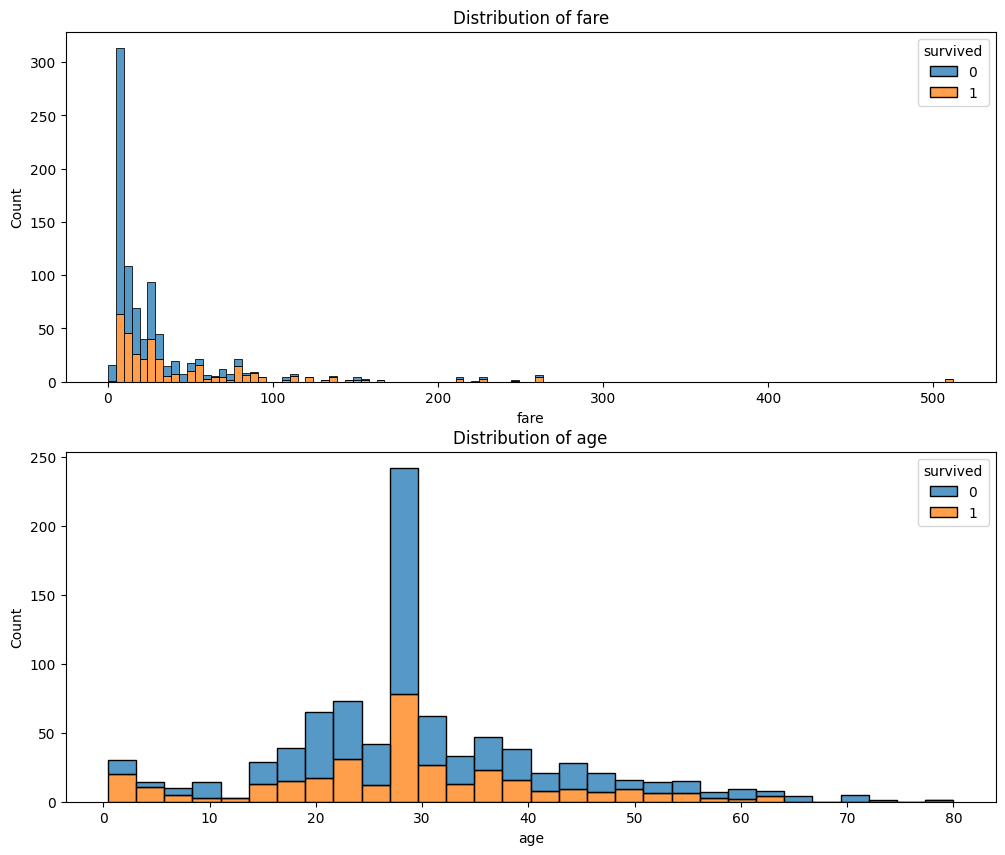

In [22]:
fig, axs = plt.subplots(2, 1, figsize = (12, 10))

for (i, column) in enumerate(['fare', 'age']):
    name = ' '.join(column.split('_'))
    sns.histplot(data = df, x = column, ax = axs[i], multiple = 'stack', hue = 'survived')
    axs[i].set_xlabel(name)
    axs[i].set_title(f'Distribution of {name}')

Посмотрим также на совместное распределение возраста и стоимости поездки:

<Axes: xlabel='age', ylabel='fare'>

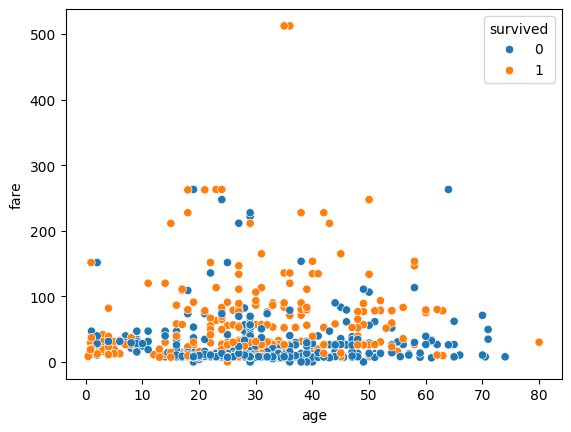

In [23]:
fig, ax = plt.subplots()
sns.scatterplot(data = df, x = 'age', y = 'fare', hue = 'survived')

Заметим, что распределение ``fare`` выглядит похожим на логнормальное распределение (за исключением людей у которых ``fare`` равно 0). Попробуем посмотреть в логарифмическом масштабе:

In [24]:
df['log_fare'] = np.nan
df.loc[df['fare'] > 0, 'log_fare'] = np.log(df.loc[df['fare'] > 0, 'fare'])

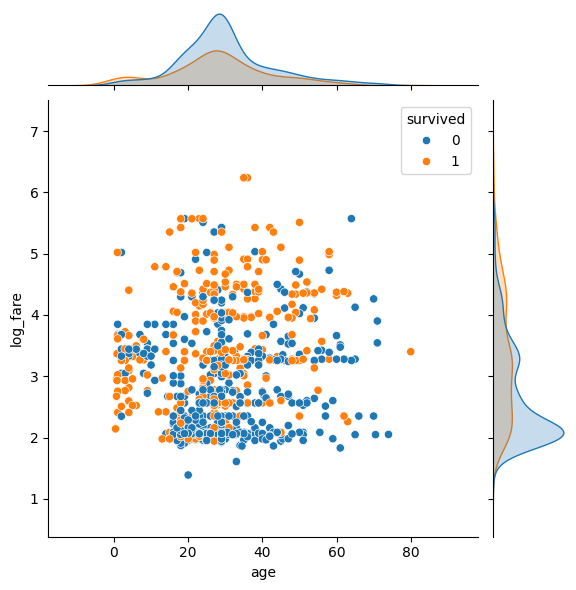

In [25]:
sns.jointplot(data = df, x = 'age', y = 'log_fare', hue = 'survived')

Видно что:
- Детям отдавали предпочтение при спасении
- Пассажиры, которые заплатили больше денег имеют более высокие шансы на спасение

Построим также ящики с усами для распределения возраста и целевой переменной по классу пассажиров:

<Axes: xlabel='pclass', ylabel='age'>

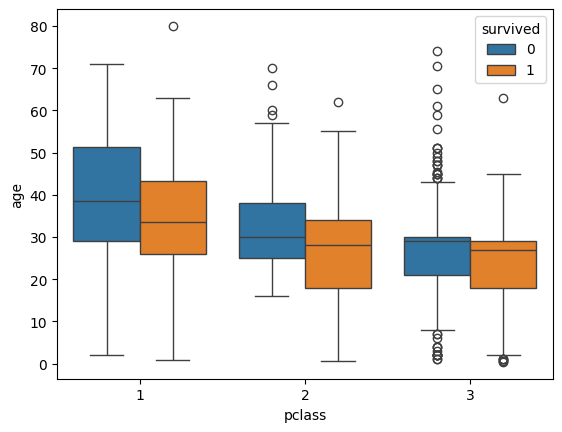

In [26]:
fig, ax = plt.subplots()
sns.boxplot(data=df, x="pclass", y="age", ax=ax, hue="survived")

Во-первых, возраст и класс пассажира положительно коррелированны (это согласовывается с матрицей корреляцией). Видимо это следствие того что чем старше человек, тем больше шансов того что он будет состоятельным. Во вторых опять проявляется тенденция к тому что меньшие значения возраста увеличивают шансы на выживание.

In [27]:
df.head()

,survived,pclass,female,age,sibsp,parch,fare,embarked,cabin_number,cabin_level,...,is_pclass_2,is_pclass_3,is_cabin_group_cn_0_25,is_cabin_group_cn_25_50,is_cabin_group_cn_50_75,is_cabin_group_cn_75_100,is_cabin_group_cn_100_125,is_cabin_group_cn_125_150,is_embarked_as_S,log_fare
0,0,3,0,22.0,1,0,7.2500,S,NaN,NaN,...,0,1,0,0,0,0,0,0,NaN,1.981001
1,1,1,1,38.0,1,0,71.2833,C,85.0,C,...,0,0,0,0,0,1,0,0,NaN,4.266662
2,1,3,1,26.0,0,0,7.9250,S,NaN,NaN,...,0,1,0,0,0,0,0,0,NaN,2.070022
3,1,1,1,35.0,1,0,53.1000,S,123.0,C,...,0,0,0,0,0,0,1,0,NaN,3.972177
4,0,3,0,35.0,0,0,8.0500,S,NaN,NaN,...,0,1,0,0,0,0,0,0,NaN,2.085672


Сделаем то же самое, но вместо группировки по классам пассажиров, будем группировать по полу:

<Axes: xlabel='female', ylabel='age'>

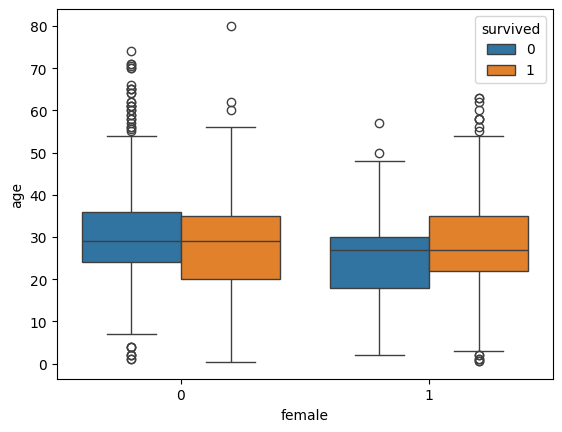

In [28]:
fig, ax = plt.subplots()
sns.boxplot(data=df, x="female", y="age", ax=ax, hue="survived")

### Категориальные признаки и значение survived

Используем критерий $\chi^2$, чтобы проверить есть ли статистически значимая связь между категориальными признаками и целевой переменной survived. Я буду использовать свою реализацию с красивой оберткой для печати результатов, без поправки Йейтса (она здесь и не нужна правда). 

In [29]:
hypothesis_side = Literal["both", "left", "right"]

class StatTestResult:
    """
    Wrapper that carries information about performed statistical test. 
    
    Attributes
    ----------
    statistics : float
        value of the test's statistics.
    p_value : float
        obtained p-value for the test's statistics.
    significance : float
        significance level for the performed test
    critical_value : float
        critical value of the test's statistics for the given significance level 
    test_name : str
        name of the test
    null_name: str
        formulation of the null hypothesis
    alternative_name : str
        formulation of the alternative hypothesis
    verdict: 
        test's verdict
    """
    def __init__(self, statistics : float, p_value : float, significance : float, critical_value : float,\
                        test_name : str, null_name : str, alternative_name : str):
        self.statistics = statistics
        self.p_value = p_value
        self.significance = significance
        self.critical_value = critical_value
        self.name = test_name
        self.null = null_name
        self.alternative = alternative_name
        
        if p_value < significance:
            self.verdict = f"Reject H0 at significance level {significance}"
        else:
            self.verdict = f"Accept H0 at significance level {significance}"

    def __repr__(self):
        return f"""
        {self.name}. 
        H0: {self.null}
        H1: {self.alternative}
        ===================================
        Statistics value: {self.statistics}. Critical value: {self.critical_value}
        P-value: {self.p_value}, 
        Verdict: {self.verdict}
        """
    def __str__(self):
        return f"Statistics: {self.statistics}, P-value: {self.p_value}"

def chi2_contingency(observed : ArrayLike, significance : float = 0.05) -> StatTestResult:
    """
        Performs chi-square independence test test for contingency table
        
        Parameters
        ----------
        observed : ArrayLike
            contingency tablefor the test 
        significance : float
            significance level for the performed test
            
        Returns
        -------
        res : StatTestResult
            An object containing infomration about test results
    """
    dof = (observed.shape[0] - 1) * (observed.shape[1] - 1)
    expected = 1/np.sum(observed) * \
                np.tile(np.sum(observed, axis = 0), (observed.shape[0], 1)) *\
                np.tile(np.sum(observed, axis = 1), (observed.shape[1], 1)).transpose()
    
    statistics = np.sum((observed - expected) ** 2 / expected)
    critical_value = stats.chi2(df = dof).ppf(1 - significance)
    p_value = 1 - stats.chi2(df = dof).cdf(statistics)
    return StatTestResult(statistics, p_value, significance, critical_value, 
                              "Pearson Chi Square Independence test", f"Rows and columns are independent",  f"Rows and columns are dependent")

Проверим следующие признаки:
- 'female'
- 'married'
- 'child'
- 'embarked'


In [30]:
crosstable = crosstable = pd.crosstab(df.survived, df.female)
crosstable.head()

female,0,1
survived,,
0,468,81
1,109,233


In [31]:
chi2_contingency(crosstable.values)


        Pearson Chi Square Independence test. 
        H0: Rows and columns are independent
        H1: Rows and columns are dependent
        Statistics value: 263.05057407065567. Critical value: 3.841458820694124
        P-value: 0.0, 
        Verdict: Reject H0 at significance level 0.05
        

In [32]:
crosstable = crosstable = pd.crosstab(df.survived, df.married)
crosstable.head()

married,0,1
survived,,
0,87,462
1,162,180


In [33]:
chi2_contingency(crosstable.values)


        Pearson Chi Square Independence test. 
        H0: Rows and columns are independent
        H1: Rows and columns are dependent
        Statistics value: 103.98088424270325. Critical value: 3.841458820694124
        P-value: 0.0, 
        Verdict: Reject H0 at significance level 0.05
        

In [34]:
crosstable = crosstable = pd.crosstab(df.survived, df.child)
crosstable.head()

child,0,1
survived,,
0,532,17
1,319,23


In [35]:
chi2_contingency(crosstable.values)


        Pearson Chi Square Independence test. 
        H0: Rows and columns are independent
        H1: Rows and columns are dependent
        Statistics value: 6.470926694879594. Critical value: 3.841458820694124
        P-value: 0.010965334026465379, 
        Verdict: Reject H0 at significance level 0.05
        

In [36]:
crosstable = pd.crosstab(df.survived, df.embarked)
crosstable.head()

embarked,C,Q,S
survived,,,
0,75,47,427
1,93,30,219


In [37]:
chi2_contingency(crosstable.values)


        Pearson Chi Square Independence test. 
        H0: Rows and columns are independent
        H1: Rows and columns are dependent
        Statistics value: 25.964452881874777. Critical value: 5.991464547107979
        P-value: 2.300862648185742e-06, 
        Verdict: Reject H0 at significance level 0.05
        

Итоги: все эти признаки существенно связаны со значением переменной survived. По некоторой непонятной причине, порт отправления тоже связан, хотя как эта связь может быть устроена - непонятно. 

Проверим теперь наличие связи между признаками отражающими информацию о каюте пассажира и целевой переменной. Так как данных мало, проверять будем на значимости 0.1

In [38]:
crosstable = pd.crosstab(df.survived, df.cabin_group)
crosstable.head()

cabin_group,cn_0_25,cn_25_50,cn_50_75,cn_75_100,cn_100_125,cn_125_150
survived,,,,,,
0,13,23,11,11,7,1
1,41,42,17,18,13,3


In [39]:
chi2_contingency(crosstable.values, significance = 0.1)


        Pearson Chi Square Independence test. 
        H0: Rows and columns are independent
        H1: Rows and columns are dependent
        Statistics value: 3.0842764930944733. Critical value: 9.236356899781123
        P-value: 0.6869945860988127, 
        Verdict: Accept H0 at significance level 0.1
        

In [40]:
crosstable = pd.crosstab(df.survived, df.cabin_level)
crosstable.head()

cabin_level,T,A,B,C,D,E,F,G
survived,,,,,,,,
0,1,8,12,24,8,8,5,2
1,0,7,35,35,25,24,8,2


In [41]:
chi2_contingency(crosstable.values, significance = 0.1)


        Pearson Chi Square Independence test. 
        H0: Rows and columns are independent
        H1: Rows and columns are dependent
        Statistics value: 10.300556313502582. Critical value: 12.017036623780532
        P-value: 0.17217134128214395, 
        Verdict: Accept H0 at significance level 0.1
        

Вердикт немного неожиданный: кабина (по крайне мере её уровень и её группа по номеру) не имеет статистически значимого влияния на значение целевой переменной. Это, конечно, может быть связано с тем что у нас не так много информации о том, какие пассажиры какие заняли каюты, но если потребуется уменьшать размерность признаков, то признаки связанные с кабиной следует пусть под нож первыми.